#PROJECT: Impact of Pricing and Promotion Strategies on Sales

# **Introduction**

This project aims to analyze the impact of various pricing and promotional strategies on sales and revenue. Using advanced machine learning models, we will explore the effectiveness of direct discounts, quantity discounts, bundle promotions, and coupon usage on customer purchasing behavior. Our objective is to provide actionable insights to optimize pricing and promotional strategies for maximizing sales and revenue.

# **Dataset Overview**
We are utilizing transaction-level data from JD.com, China’s largest retailer, provided for the 2020 MSOM Data Driven Research Challenge. The dataset captures a complete customer experience cycle, from browsing to delivery, for over 2.5 million customers and 31,868 SKUs during March 2018. It includes detailed records of orders, pricing, promotions, customer demographics, and product attributes, enabling a comprehensive analysis of sales dynamics.

# DATA PREPROCESSING

In [ ]:
#IMPORT LIBRARIES

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Transformation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature Engineering and Selection
from sklearn.feature_selection import SelectFromModel

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Model Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy import stats


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:

#folder_path = '/content/drive/My Drive/Colab Notebooks/IS_proj_JD_com'
folder_path = '/content/drive/MyDrive/Colab Notebooks/IS_proj_JD_com'
orders = pd.read_csv(folder_path + '/JD_order_data.csv')
skus = pd.read_csv(folder_path + '/JD_sku_data.csv') # it only has brand data so not much useful
users = pd.read_csv(folder_path + '/JD_user_data.csv')
clicks = pd.read_csv(folder_path + '/JD_click_data.csv') #  if sth was clicked but not bought as well as its platform

In [ ]:
orders.head()

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
0,d0cf5cc6db,0abe9ef2ce,581d5b54c1,2018-03-01,2018-03-01 17:14:25.0,1,2,-,89.0,79.0,0.0,10.0,0.0,0.0,0,4,28
1,7444318d01,33a9e56257,067b673f2b,2018-03-01,2018-03-01 11:10:40.0,1,1,2,99.9,53.9,5.0,41.0,0.0,0.0,0,28,28
2,f973b01694,4ea3cf408f,623d0a582a,2018-03-01,2018-03-01 09:13:26.0,1,1,2,78.0,58.5,19.5,0.0,0.0,0.0,0,28,28
3,8c1cec8d4b,b87cb736cb,fc5289b139,2018-03-01,2018-03-01 21:29:50.0,1,1,2,61.0,35.0,0.0,26.0,0.0,0.0,0,4,28
4,d43a33c38a,4829223b6f,623d0a582a,2018-03-01,2018-03-01 19:13:37.0,1,1,1,78.0,53.0,19.0,0.0,0.0,6.0,0,3,16


In [ ]:
clicks.head()

,sku_ID,user_ID,request_time,channel
0,a234e08c57,4c3d6d10c2,2018-03-01 23:57:53,wechat
1,6449e1fd87,-,2018-03-01 16:13:48,wechat
2,09b70fcd83,2791ec4485,2018-03-01 22:10:51,wechat
3,09b70fcd83,eb0718c1c9,2018-03-01 16:34:08,wechat
4,09b70fcd83,59f84cf342,2018-03-01 22:20:35,wechat


In [ ]:
users.head()

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,000089d6a6,1,2017-08,0,F,26-35,S,3,4,3
1,0000babd1f,1,2018-03,0,U,U,U,-1,-1,-1
2,0000bc018b,3,2016-06,0,F,>=56,M,3,2,3
3,0000d0e5ab,3,2014-06,0,M,26-35,M,3,2,2
4,0000dce472,3,2012-08,1,U,U,U,-1,-1,-1


### Check for duplicates before merging

In [ ]:
orders.duplicated().sum()

3928

In [ ]:
# inspect duplicates in a table sorted by order_ID
duplicates = orders[orders.duplicated(keep=False)]

duplicates_sorted = duplicates.sort_values(by='order_ID')

duplicates_sorted.head()


,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
114857,00077fb259,ea0904c510,a9109972d1,2018-03-06,2018-03-06 20:08:34.0,1,2,-,0.0,0.0,0.0,0.0,0.0,0.0,1,9,25
114858,00077fb259,ea0904c510,a9109972d1,2018-03-06,2018-03-06 20:08:34.0,1,2,-,0.0,0.0,0.0,0.0,0.0,0.0,1,9,25
295215,000a310059,6ae7406d31,15bb848d24,2018-03-17,2018-03-17 10:44:48.0,1,2,-,0.0,0.0,0.0,0.0,0.0,0.0,1,5,5
295216,000a310059,6ae7406d31,15bb848d24,2018-03-17,2018-03-17 10:44:48.0,1,2,-,0.0,0.0,0.0,0.0,0.0,0.0,1,5,5
129008,002f04956e,d02e56d590,a9109972d1,2018-03-07,2018-03-07 15:07:58.0,2,2,-,0.0,0.0,0.0,0.0,0.0,0.0,1,9,61


In [ ]:
#DR0P DUPLICATES
# Upon inspection, we see these are true duplicates, with exact same order_ID and details.
# We would expect at least order id to vary, so we are dropping duplicates
orders = orders.drop_duplicates()
print(orders.duplicated().sum())

0


In [ ]:
#check for users duplicates - > none
users.duplicated().sum()

0

In [ ]:
#check for clicks duplicates
clicks.duplicated().sum()

0

In [ ]:
#Remove clicks exact duplicates
clicks = clicks.drop_duplicates()
print(clicks.duplicated().sum())

0


In [ ]:
print(clicks.shape)
print(orders.shape)
print(users.shape)

(19727248, 4)
(546061, 17)
(457298, 10)


## Merge 3 tables to get insights

### Since tables are very big we choose a subset of orders for analysis now

In [ ]:
#number of unique order IDs
unique_order_ids = orders['order_ID'].nunique()
print("Number of unique order IDs:", unique_order_ids)

Number of unique order IDs: 486928


In [ ]:
#number of unique order IDs
unique_user_ids = orders['user_ID'].nunique()
print("Number of unique user IDs:", unique_user_ids)

Number of unique user IDs: 454897


In [ ]:
#number of unique order IDs
unique_user_ids = users['user_ID'].nunique()
print("Number of unique user IDs:", unique_user_ids)

Number of unique user IDs: 457298


In [ ]:
users.columns

Index(['user_ID', 'user_level', 'first_order_month', 'plus', 'gender', 'age',
       'marital_status', 'education', 'city_level', 'purchase_power'],
      dtype='object')

In [ ]:
#stratifying and randomly choose 20% of the users
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def balanced_sampling(df, sample_fraction=0.2):
    stratify_cols = ['user_level', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power']

    # Create a stratification key
    df['stratify_key'] = df[stratify_cols].astype(str).agg('-'.join, axis=1)

    # Ensure at least two samples per group
    value_counts = df['stratify_key'].value_counts()
    valid_classes = value_counts[value_counts >= 2].index  # Keep only groups with at least 2 members
    df_filtered = df[df['stratify_key'].isin(valid_classes)]

    if df_filtered.empty:
        raise ValueError("Too many unique categories; consider reducing stratification features.")

    # Apply stratified sampling
    sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_fraction, random_state=42)

    for _, sample_idx in sss.split(df_filtered, df_filtered['stratify_key']):
        sampled_df = df_filtered.iloc[sample_idx]

    sampled_df = sampled_df.drop(columns=['stratify_key'])

    return sampled_df

sampled_users = balanced_sampling(users)
sampled_users



,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
303609,a9959bb7b4,1,2017-11,0,F,36-45,S,3,-1,3
85761,2f88ddd05b,4,2011-10,1,M,36-45,M,4,1,2
86671,30144fbecc,4,2014-02,1,F,26-35,M,3,2,2
31922,11a2d50102,4,2012-09,0,F,26-35,M,3,1,2
392142,db7b2e427c,4,2011-07,1,M,26-35,S,4,1,2
...,...,...,...,...,...,...,...,...,...,...
404831,e28db4a730,1,2018-03,0,F,26-35,M,3,2,2
399545,dfa3b1f7aa,1,2017-10,0,U,U,U,-1,-1,-1
234584,82c59555b7,3,2016-01,0,F,36-45,S,3,2,3
284555,9edce7ef5f,1,2018-03,0,M,16-25,M,-1,2,2


In [ ]:
orders_users = pd.merge(orders, sampled_users, on='user_ID', how='inner') #If somebody did not make an order we do not need them in our analysis
orders_users

,order_ID,user_ID,sku_ID,order_date,order_time,quantity,type,promise,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,89286e5fd9,79154d0001,6717b7c979,2018-03-01,2018-03-01 22:18:41.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1,3,16,2,2015-05,0,F,16-25,U,2,2,-1
1,33b2ce65f5,e49625c3ee,83e24b70d5,2018-03-01,2018-03-01 11:17:08.0,1,1,1,79.0,62.0,0.0,16.0,0.0,1.0,0,3,16,3,2015-07,0,F,16-25,S,2,2,2
2,8027904ac7,0101524c88,5ae1bb1c76,2018-03-01,2018-03-01 05:54:36.0,1,1,1,78.0,59.0,19.0,0.0,0.0,0.0,0,3,16,2,2017-09,0,F,16-25,S,2,2,3
3,89286e5fd9,79154d0001,01c9d91829,2018-03-01,2018-03-01 22:18:41.0,1,1,1,129.0,129.0,0.0,0.0,0.0,0.0,0,3,16,2,2015-05,0,F,16-25,U,2,2,-1
4,ab47a8f853,e656394dbf,f255daf3ab,2018-03-01,2018-03-01 23:07:16.0,1,1,1,78.0,57.0,21.0,0.0,0.0,0.0,0,3,16,2,2014-09,0,M,26-35,S,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108956,80915573ca,256f3c1255,068f4481b3,2018-03-31,2018-03-31 15:29:46.0,1,1,1,298.0,228.0,70.0,0.0,0.0,0.0,0,2,2,4,2014-05,1,M,26-35,S,3,2,2
108957,eff94562d1,88e66be7b7,7e4cb4952a,2018-03-31,2018-03-31 11:33:22.0,1,1,2,59.0,59.0,0.0,0.0,0.0,0.0,0,28,28,2,2016-05,0,U,U,U,-1,-1,-1
108958,e21eff4072,a20b8f677f,32118a2170,2018-03-31,2018-03-31 15:42:29.0,1,2,-,69.0,69.0,0.0,0.0,0.0,0.0,0,2,2,1,2017-09,0,M,26-35,U,-1,2,-1
108959,6cfe6c562e,0a77cd5140,2e6929ecb9,2018-03-31,2018-03-31 21:18:03.0,1,2,-,69.0,69.0,0.0,0.0,0.0,0.0,0,2,2,2,2016-06,0,U,26-35,U,-1,2,-1


In [ ]:
pip install missingno

<Axes: >

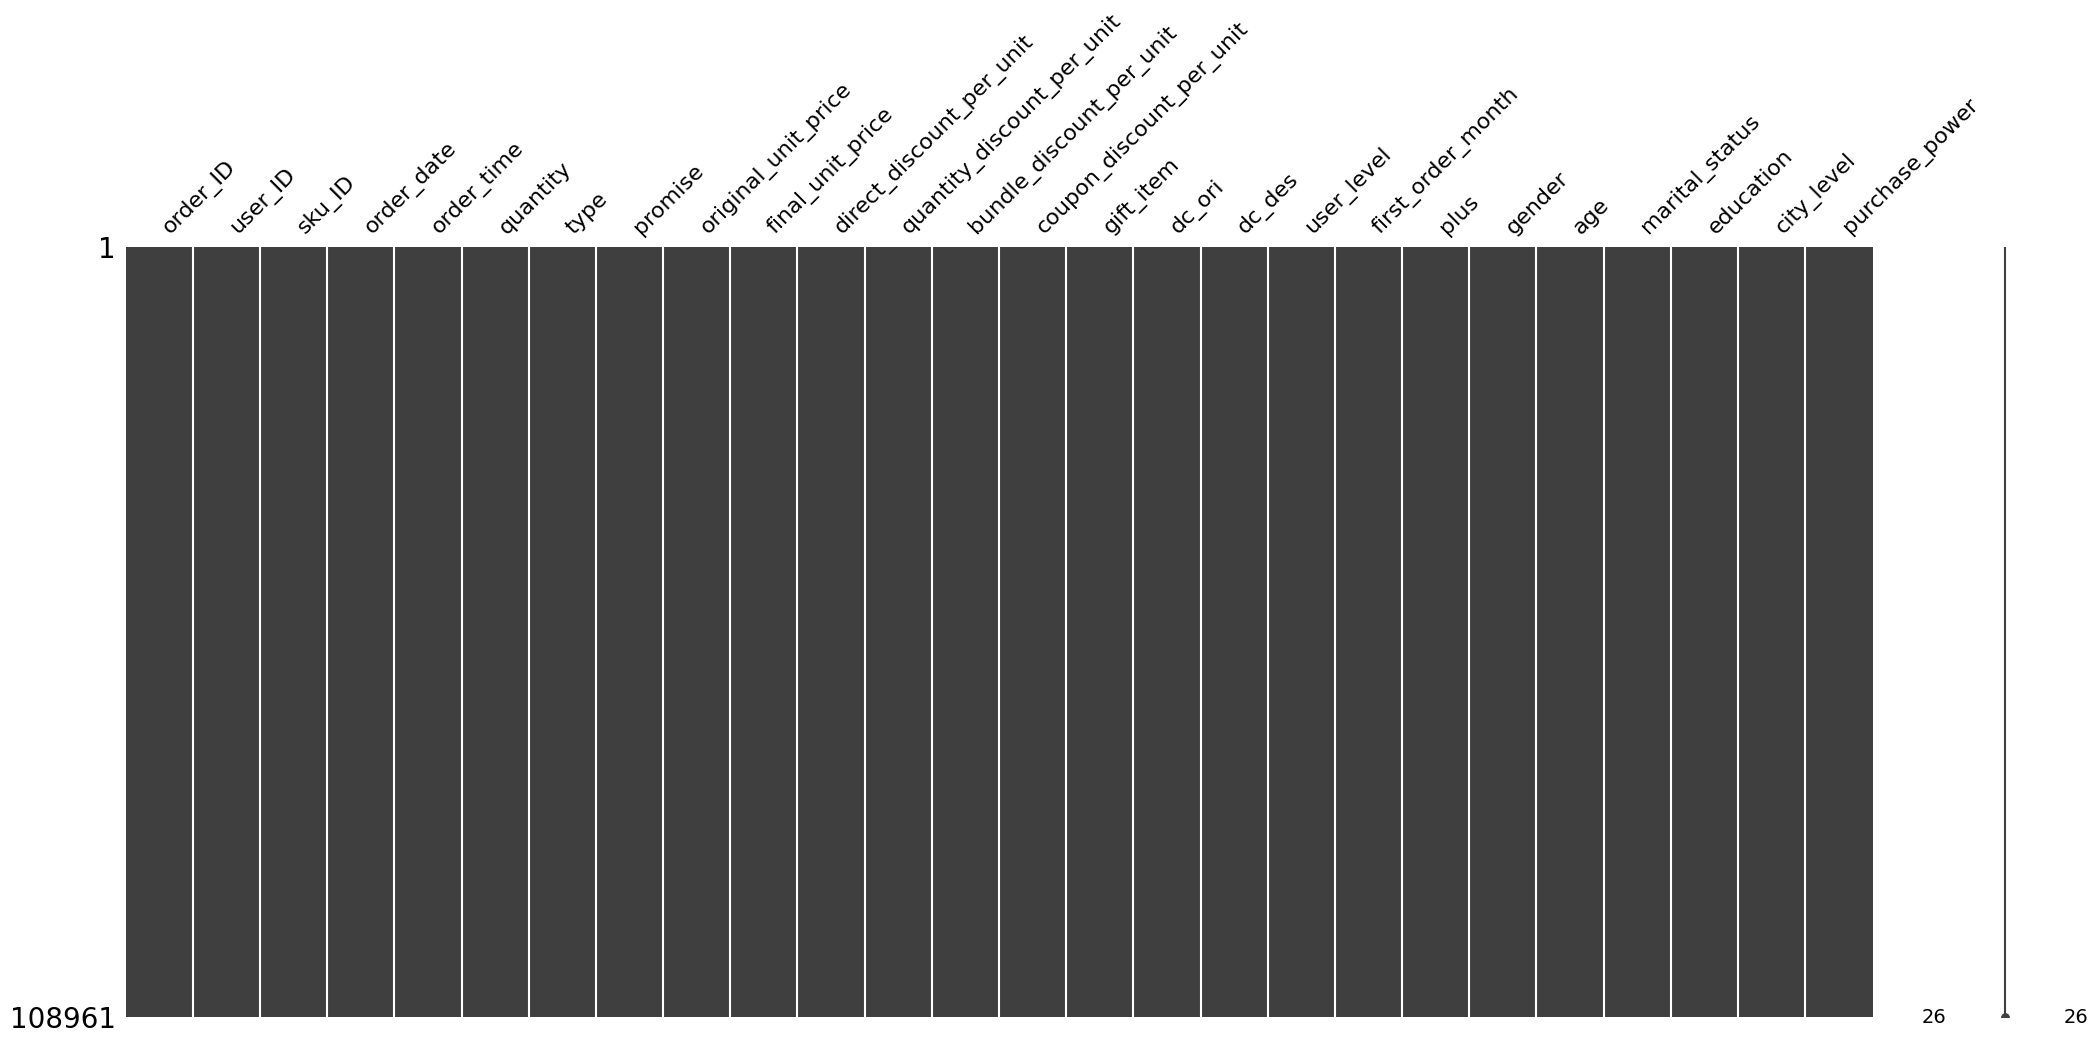

In [ ]:
import missingno as msno
msno.matrix(orders_users)

In [ ]:
orders_users['order_date'] = orders_users['order_time'].dt.date  # Extract only the date
clicks['request_date'] = clicks['request_time'].dt.date  # Extract only the date

In [ ]:
#compare clicks['request_time'] and orders_users['order_time'] to see if they have the same format
clicks['request_time'] = pd.to_datetime(clicks['request_time'], errors='coerce')
orders_users['order_time'] = pd.to_datetime(orders_users['order_time'], errors='coerce')

#show some unique values of them
print(clicks['request_time'].unique())
print(orders_users['order_time'].unique())

<DatetimeArray>
['2018-03-01 23:57:53', '2018-03-01 16:13:48', '2018-03-01 22:10:51',
 '2018-03-01 16:34:08', '2018-03-01 22:20:35', '2018-03-01 22:20:01',
 '2018-03-01 22:19:11', '2018-03-01 08:08:06', '2018-03-01 08:13:29',
 '2018-03-01 08:08:08',
 ...
 '2018-03-31 03:25:30', '2018-03-31 04:48:16', '2018-03-31 05:25:31',
 '2018-03-31 04:05:55', '2018-03-31 05:12:49', '2018-03-31 04:22:51',
 '2018-03-31 01:42:39', '2018-03-31 04:21:57', '2018-03-31 05:35:59',
 '2018-03-31 05:32:03']
Length: 2403971, dtype: datetime64[ns]
<DatetimeArray>
['2018-03-01 22:18:41', '2018-03-01 11:17:08', '2018-03-01 05:54:36',
 '2018-03-01 23:07:16', '2018-03-01 22:30:08', '2018-03-01 01:11:04',
 '2018-03-01 13:55:17', '2018-03-01 23:15:32', '2018-03-01 14:30:14',
 '2018-03-01 20:21:50',
 ...
 '2018-03-31 12:45:34', '2018-03-31 13:24:36', '2018-03-31 06:03:08',
 '2018-03-31 15:10:42', '2018-03-31 11:06:24', '2018-03-31 15:29:46',
 '2018-03-31 11:33:22', '2018-03-31 15:42:29', '2018-03-31 21:18:03',
 '2018-

In [ ]:
common_times = set(orders_users['order_time']).intersection(set(clicks['request_time']))
print(len(common_times))  # Should be greater than 0 for a successful merge


92649


In [ ]:
#show some unique values of them
print(clicks['request_date'].unique())
print(orders_users['order_date'].unique())

[datetime.date(2018, 3, 1) datetime.date(2018, 2, 28)
 datetime.date(2018, 3, 2) datetime.date(2018, 3, 3)
 datetime.date(2018, 3, 4) datetime.date(2018, 3, 5)
 datetime.date(2018, 3, 6) datetime.date(2018, 3, 7)
 datetime.date(2018, 3, 8) datetime.date(2018, 3, 9)
 datetime.date(2018, 3, 10) datetime.date(2018, 3, 11)
 datetime.date(2018, 3, 12) datetime.date(2018, 3, 13)
 datetime.date(2018, 3, 14) datetime.date(2018, 3, 15)
 datetime.date(2018, 3, 16) datetime.date(2018, 3, 17)
 datetime.date(2018, 3, 18) datetime.date(2018, 3, 19)
 datetime.date(2018, 3, 20) datetime.date(2018, 3, 21)
 datetime.date(2018, 3, 22) datetime.date(2018, 3, 23)
 datetime.date(2018, 3, 24) datetime.date(2018, 3, 25)
 datetime.date(2018, 3, 26) datetime.date(2018, 3, 27)
 datetime.date(2018, 3, 28) datetime.date(2018, 3, 29)
 datetime.date(2018, 3, 30) datetime.date(2018, 3, 31)]
[datetime.date(2018, 3, 1) datetime.date(2018, 3, 2)
 datetime.date(2018, 3, 3) datetime.date(2018, 3, 4)
 datetime.date(2018, 3

In [ ]:
common_dates = set(orders_users['order_date']).intersection(set(clicks['request_date']))
print(len(common_dates))  # Should be greater than 0 for a successful merge

31


In [ ]:
#Merge orders and clicks on 'user_id', 'sku_id' and 'order_time'=request_time
df = pd.merge(orders_users, clicks, left_on=['user_ID', 'sku_ID', 'order_date'], right_on = ['user_ID', 'sku_ID', 'request_date'], how='right')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19733951 entries, 0 to 19733950
Data columns (total 29 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   order_ID                    object        
 1   user_ID                     object        
 2   sku_ID                      object        
 3   order_date                  object        
 4   order_time                  datetime64[ns]
 5   quantity                    float64       
 6   type                        float64       
 7   promise                     object        
 8   original_unit_price         float64       
 9   final_unit_price            float64       
 10  direct_discount_per_unit    float64       
 11  quantity_discount_per_unit  float64       
 12  bundle_discount_per_unit    float64       
 13  coupon_discount_per_unit    float64       
 14  gift_item                   float64       
 15  dc_ori                      float64       
 16  dc_des          

In [ ]:
# Keep only rows where order_date > request_date
df = df[df['order_time'] > df['request_time']]

In [ ]:
df.shape

(19733951, 29)

In [ ]:
#check not null values in order_ID
df['order_ID'].notnull().sum()

341042

<Axes: >

/usr/local/lib/python3.11/dist-packages/matplotlib/image.py:183: UserWarning: Data with more than 2**24 rows cannot be accurately displayed. Downsampling to less than 2**24 rows before displaying. To remove this warning, manually downsample your data.
  warnings.warn(msg.format(n='2**24 rows'))


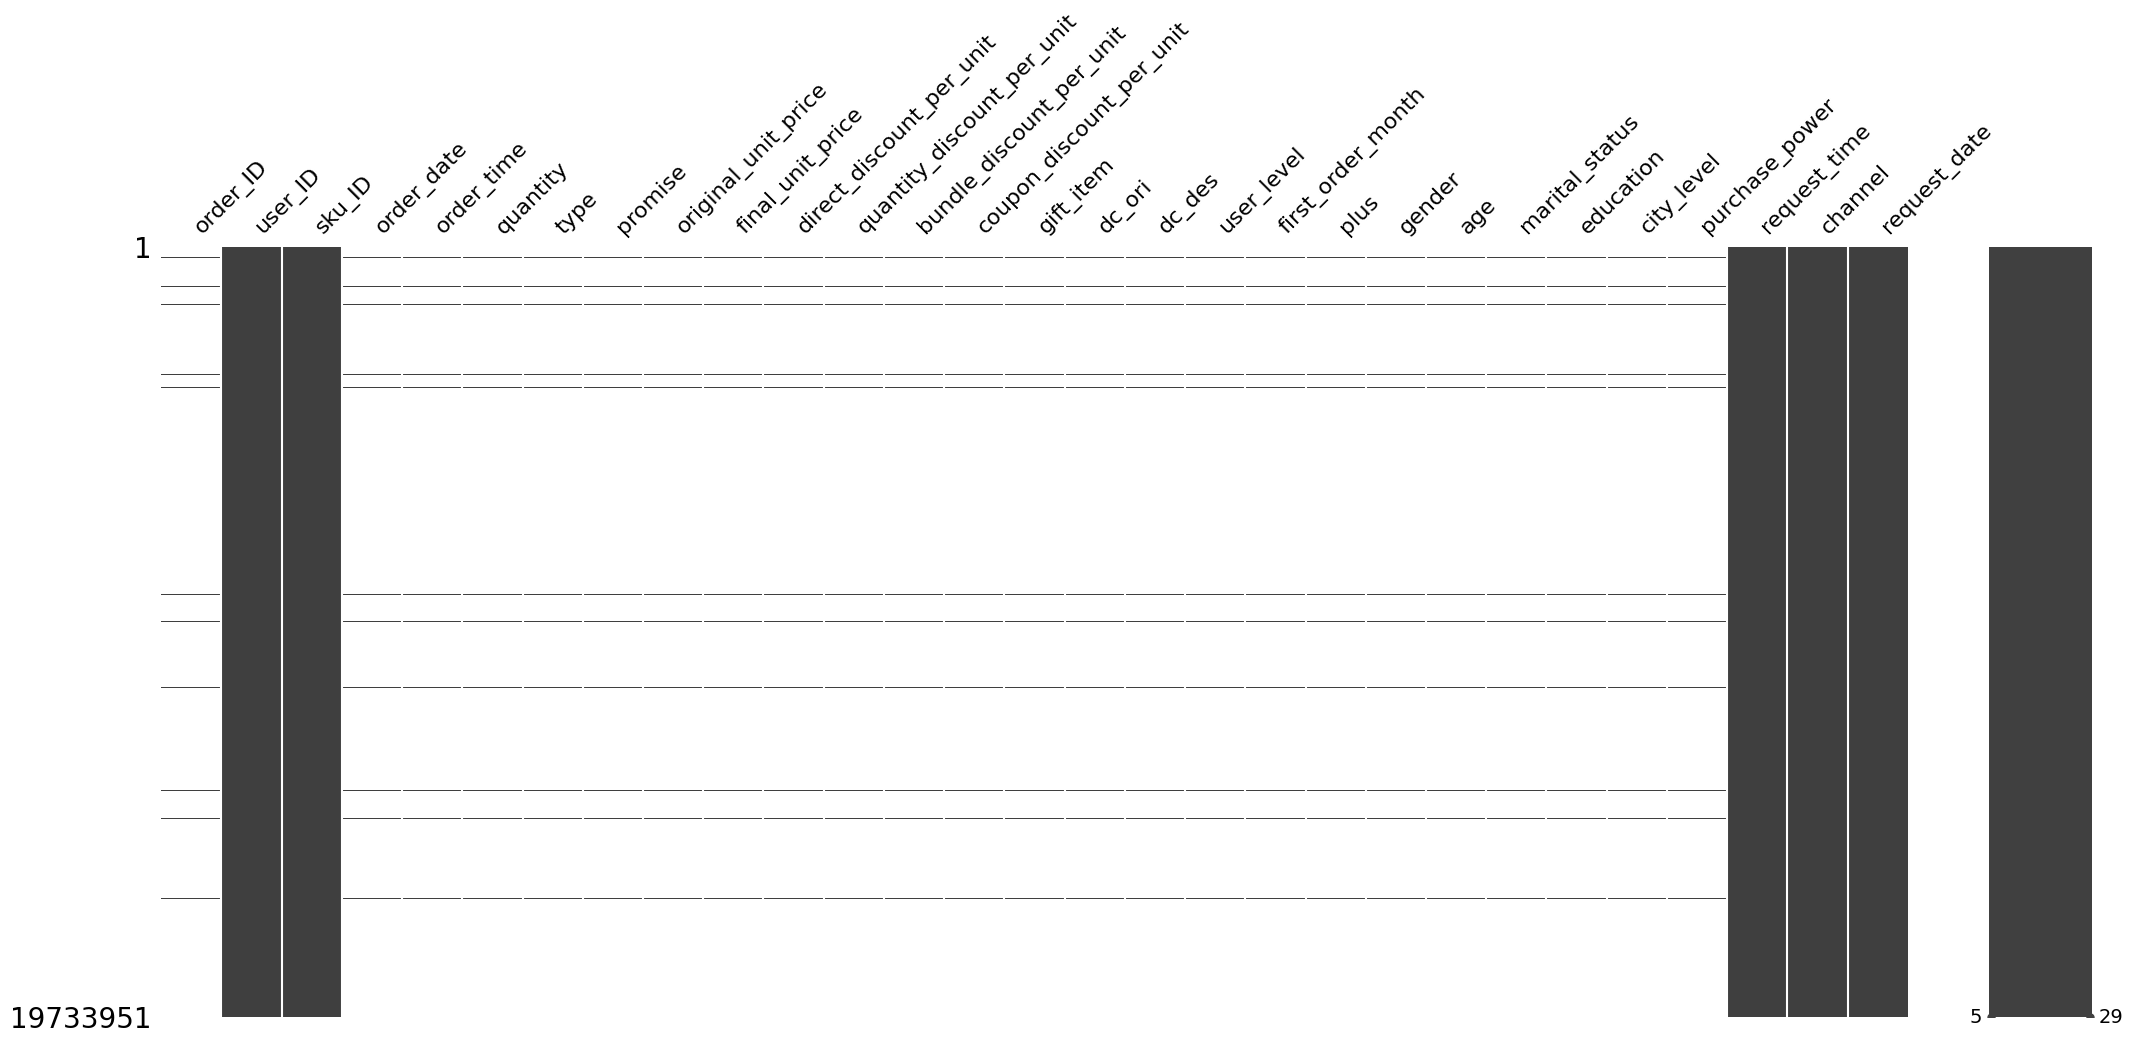

In [ ]:
import missingno as msno
msno.matrix(df)

In [ ]:
#Filter the df for the users existing in sampled_users
df = df[df['user_ID'].isin(sampled_users['user_ID'])]
df.shape

(1199597, 29)

In [ ]:
# Apply the condition within each (user_ID, sku_ID) group
df = df.groupby(['user_ID', 'sku_ID']).apply(lambda g: g[g['order_time'] > g['request_time']])
df.shape

In [ ]:
df.to_csv('merged_table_users_orders_clicks_sampled.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546061 entries, 0 to 546060
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_ID                    546061 non-null  object 
 1   user_ID                     546061 non-null  object 
 2   sku_ID                      546061 non-null  object 
 3   order_date                  546061 non-null  object 
 4   order_time                  546061 non-null  object 
 5   quantity                    546061 non-null  int64  
 6   type                        546061 non-null  int64  
 7   promise                     546061 non-null  object 
 8   original_unit_price         546061 non-null  float64
 9   final_unit_price            546061 non-null  float64
 10  direct_discount_per_unit    546061 non-null  float64
 11  quantity_discount_per_unit  546061 non-null  float64
 12  bundle_discount_per_unit    546061 non-null  float64
 13  coupon_discoun

In [ ]:
df.describe()

,quantity,type,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des,user_level,plus,education,city_level,purchase_power
count,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000,546061.000000
mean,1.216201,1.497225,103.553114,72.087445,19.988648,7.899810,0.630150,2.947063,0.166058,12.094682,21.693291,2.399635,0.182375,1.944757,1.677089,1.577606
std,1.850448,0.499993,94.974426,75.907404,33.671798,18.046613,6.465191,11.627275,0.372133,14.236116,16.976740,1.345765,0.386154,1.755760,1.615179,1.458747
min,1.000000,1.000000,0.000000,-32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,1.000000,59.000000,33.900000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000,1.000000,0.000000,1.000000,1.000000,2.000000
50%,1.000000,1.000000,79.000000,58.000000,4.000000,0.000000,0.000000,0.000000,0.000000,7.000000,20.000000,2.000000,0.000000,3.000000,2.000000,2.000000
75%,1.000000,2.000000,139.000000,95.000000,21.000000,0.000000,0.000000,0.000000,0.000000,10.000000,34.000000,3.000000,0.000000,3.000000,3.000000,2.000000
max,400.000000,2.000000,12158.000000,12158.000000,720.000000,225.000000,252.000000,210.000000,1.000000,67.000000,67.000000,10.000000,1.000000,4.000000,5.000000,5.000000


In [ ]:
df.isna().sum()

,0
order_ID,0
user_ID,0
sku_ID,0
order_date,0
order_time,0
quantity,0
type,0
promise,0
original_unit_price,0
final_unit_price,0


In [ ]:
#explore attributes
df["attribute1"].value_counts()

,count
attribute1,
3.0,259841
2.0,91557
-,84579
4.0,80577
1.0,7951


In [ ]:
df["attribute2"].value_counts()

,count
attribute2,
100.0,216784
-,106955
60.0,98676
80.0,28080
70.0,22213
50.0,21839
90.0,16218
40.0,8404
30.0,5336


Dealing with Null Values:

*   Deactivate & Activate Dates - Only shown when variables fall within March. Given most of these are null due to this, we will drop those column.
*attribute 1 & 2 - impute with the mode for attribute1 and attribute2 because higher values indicate better performance, and the mode represents the most common level of performance; this approach aims to minimize the impact of imputation on the overall distribution while leaning towards a more favorable outcome.


In [ ]:
df2 = df.copy()

In [ ]:
#dealing with null values
df2 = df2.dropna(subset=['brand_ID'])
df2 = df2.drop(columns=['activate_date', 'deactivate_date'])

df2['attribute1'] = df2['attribute1'].replace('-', np.nan)
df2['attribute1'] = pd.to_numeric(df2['attribute1'], errors='coerce')
df2['attribute1'] = df2['attribute1'].fillna(df2['attribute1'].mode()[0])


df2['attribute2'] = df2['attribute2'].replace('-', np.nan)
df2['attribute2'] = pd.to_numeric(df2['attribute2'], errors='coerce')
df2['attribute2'] = df2['attribute2'].fillna(df2['attribute2'].mode()[0])






HANDLING CATEGORICAL VARIABLES

In [ ]:
#check distribution of categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df2, x=col)
    plt.title(f'Countplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
#FIX DATE & TIME FORMATTING
df2['order_date'] = pd.to_datetime(df2['order_date'], errors='coerce')
df2['order_time'] = pd.to_datetime(df2['order_time'], errors='coerce')
df2['day_of_month'] = df2['order_date'].dt.day #given year and month are the same for all, this is the only relevant information
df2['day_of_week'] = df2['order_date'].dt.dayofweek  #

In [ ]:
object_cols = df2.select_dtypes(include='object').columns


unique_counts = pd.DataFrame(index=object_cols, columns=['Unique Value Count'])

for col in object_cols:
    unique_counts.loc[col, 'Unique Value Count'] = df2[col].nunique()


print(unique_counts)


                  Unique Value Count
order_ID                      467633
user_ID                       437259
sku_ID                          8832
promise                            9
brand_ID                        1063
first_order_month                169
gender                             3
age                                7
marital_status                     3


Exploring categorical variables

**HANDLING CATEGORICAL VARIABLES**

In [ ]:

#PROMISE REPRESENTS DELIVERY DAYS PROMISED, WE WILL IMPUTE MISSING VALUES WITH MEDIAN
df2['promise'] = df2['promise'].replace('-', np.nan)
df2['promise'] = pd.to_numeric(df2['promise'], errors='coerce')
df2['promise'] = df2['promise'].fillna(df2['promise'].median())

#first_Order_month
# derive month & year & delete original column
df2['first_order_month'] = pd.to_datetime(df2['first_order_month'], errors='coerce')
df2['first_order_month_num'] = df2['first_order_month'].dt.month
df2['first_order_year'] = df2['first_order_month'].dt.year
df2 = df2.drop('first_order_month', axis=1)

# Gender - one hot encoding
df2 = pd.get_dummies(df2, columns=['gender'], prefix='gender', drop_first=True)

# Age  (One-Hot Encoding of Ranges)
df2 = pd.get_dummies(df2, columns=['age'], prefix='age', drop_first=True)

# (One-Hot Encoding)
df2 = pd.get_dummies(df2, columns=['marital_status'], prefix='marital_status', drop_first=True)


In [ ]:
#no predictive power expected from order_ID & user_ID, so we will drop those columns.
# decision on sku_ID & brand_ID to be made post EDA - perhaps keeping specific brands/sku

df2 = df2.drop(columns=['sku_ID','brand_ID'])


CHECK FOR OUTLIERS

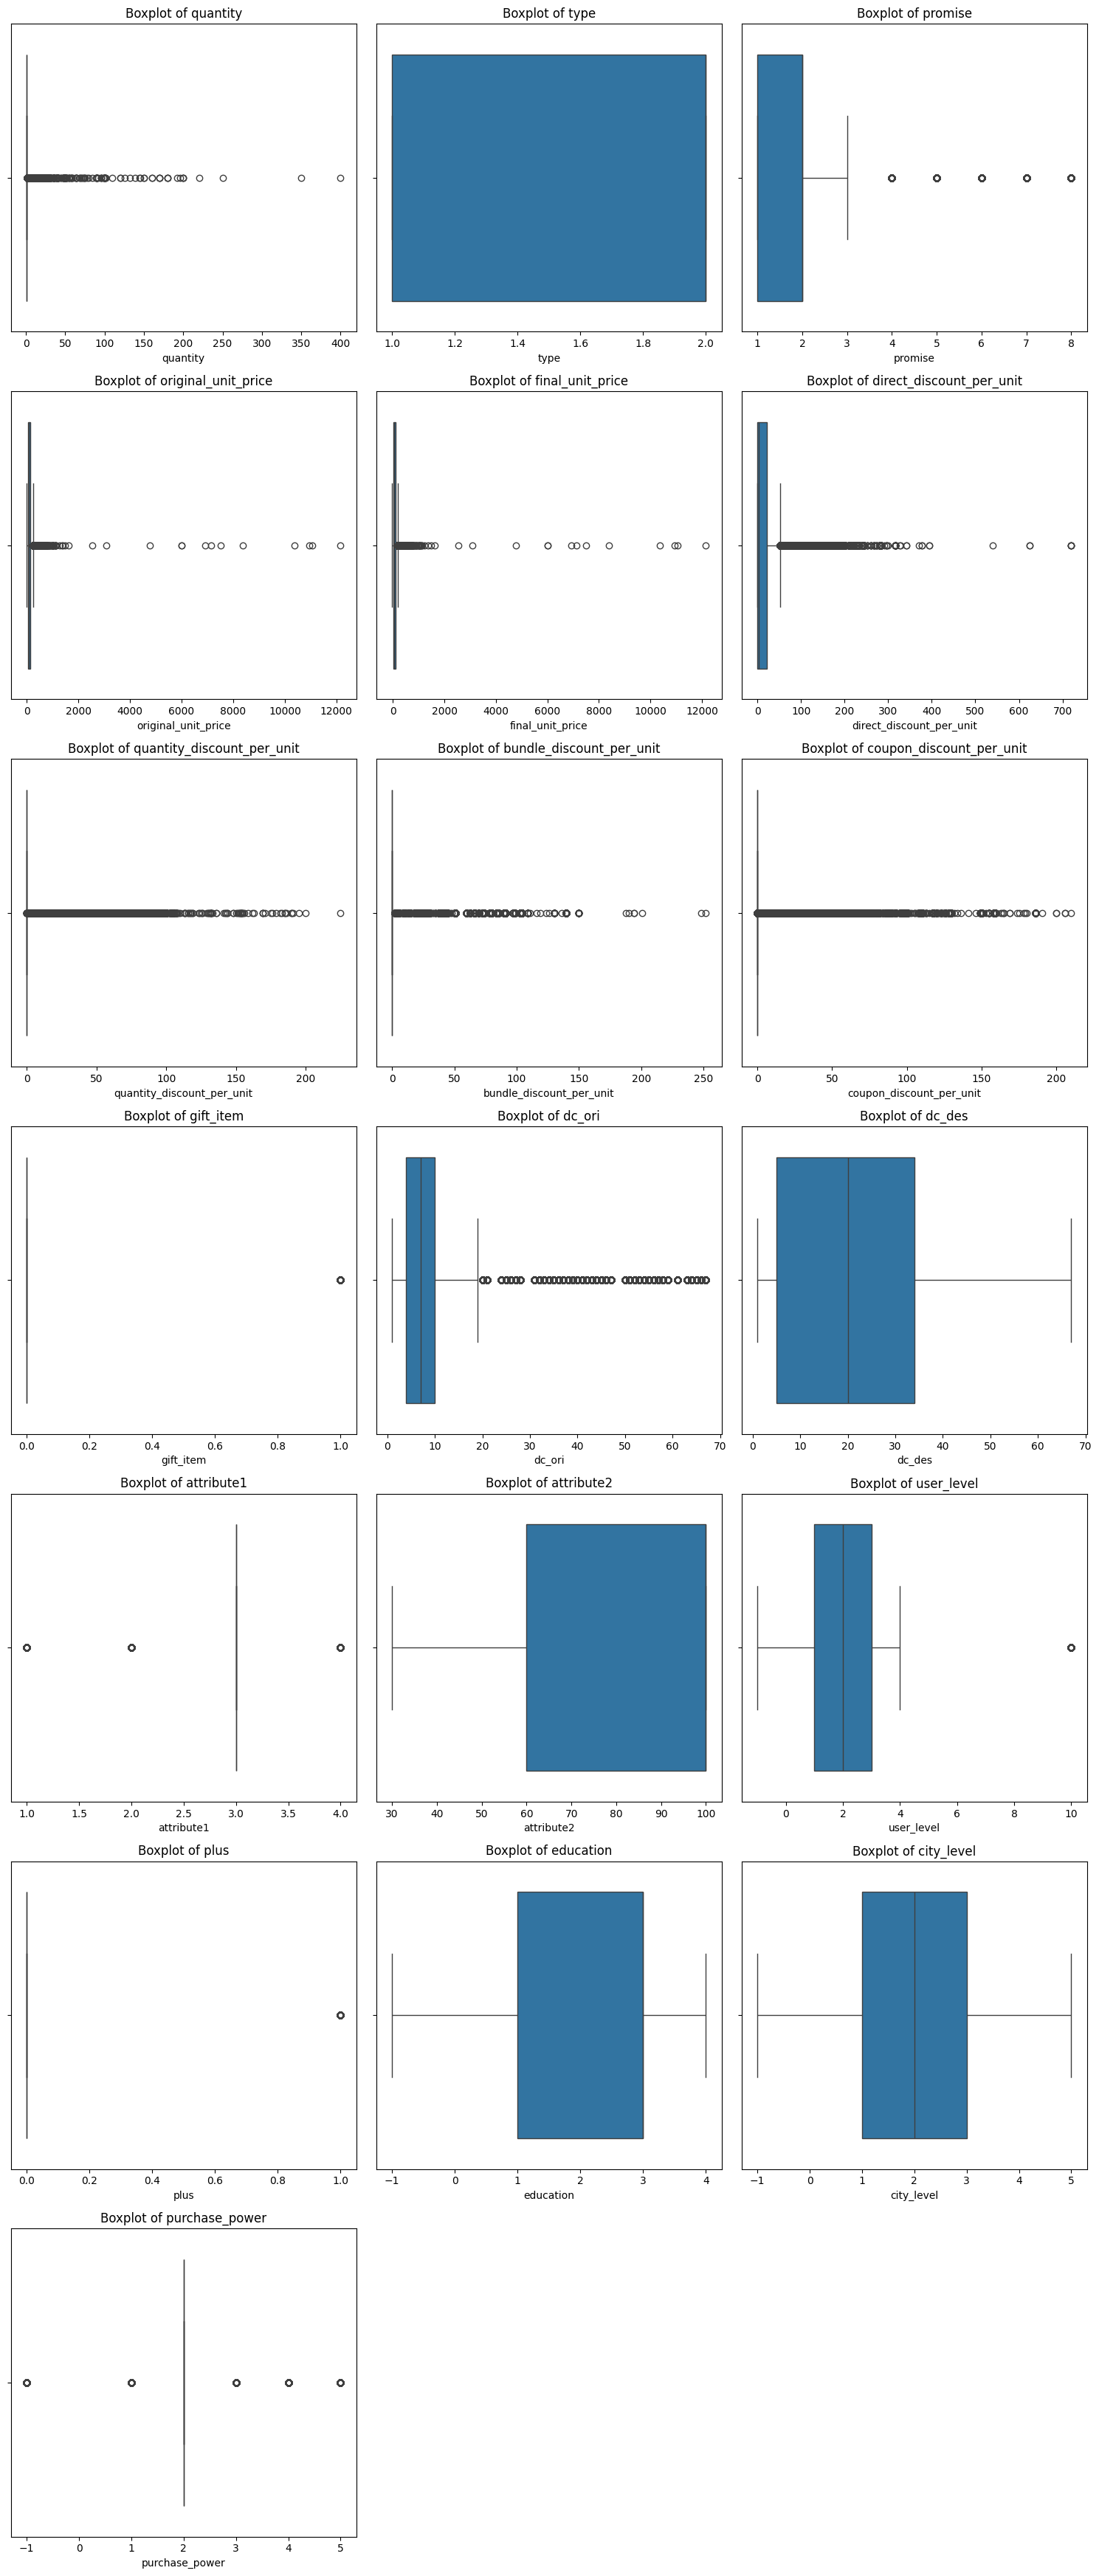

In [ ]:

#boxplot
numerical_cols = df2.select_dtypes(include=['float64', 'int64']).columns

num_cols = 3
num_rows = (len(numerical_cols) + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df2[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

# Remove any unused subplots
for i in range(len(numerical_cols), num_rows * num_cols):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


In [ ]:
# Calculate IQR and detect outliers for numeric columns only
numeric_cols = df2.select_dtypes(include='number')  # Select numeric columns
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Identifying outliers
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR)))
outlier_counts = outliers.sum()
print("Number of outliers per column:\n", outlier_counts)


Number of outliers per column:
 quantity                       67770
type                               0
promise                        40080
original_unit_price            42005
final_unit_price               38310
direct_discount_per_unit       68021
quantity_discount_per_unit    125628
bundle_discount_per_unit        7496
coupon_discount_per_unit      107863
gift_item                      87335
dc_ori                        108645
dc_des                             0
attribute1                    180085
attribute2                         0
user_level                      5456
plus                           94113
education                          0
city_level                         0
purchase_power                249216
day_of_month                       0
day_of_week                        0
first_order_month_num              0
first_order_year                5568
dtype: int64


Initial outlier insights based on interquatile method:


*   Significant outliers detected in quantity, original_unit_price,final_unit_price, and discount-related columns.
*   Mean quantity is 1.21, but max is 400, indicating a skewed distribution. Explore further, bulk orders likely impacting quantity.
* Extreme values in purchase_power and quantity_discount_per_unit.
* High variance in price and discount columns, suggesting possible segmentation of bulk buyers.


**EDA**

In [ ]:
#correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()


 Note for others:
 i've dealt with categorical variables, removed duplicates, and imputed values for attribute1, attribute 2, and delivery promise. (see if you guys agree with the methodology or if you'd rather remove)

 Next steps - we need to deal with outliers. maybe for quantity - we need to define a threshold and have that shown as bulk , ex, orders higher than 50 are i think are 0.5% of total orders